# Modeling and Simulation in Python

Chapter 6

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

from pandas import read_html

### Code from the previous chapter



In [2]:
filename = 'https://en.wikipedia.org/wiki/World_population_estimates'
tables = read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']


In [3]:
un = table2.un / 1e9
un.head()

Year
1950    2.525149
1951    2.572851
1952    2.619292
1953    2.665865
1954    2.713172
Name: un, dtype: float64

In [4]:
census = table2.census / 1e9
census.head()

Year
1950    2.557629
1951    2.594940
1952    2.636772
1953    2.682053
1954    2.730228
Name: census, dtype: float64

In [5]:
t_0 = census.index[0]
t_end = census.index[-1]
elapsed_time = t_end - t_0


p_0 = census[t_0]
p_end = census[t_end]

total_growth = p_end - p_0
annual_growth = total_growth / elapsed_time


0.07224800083333333

We can rewrite the code from the previous chapter using system objects.

In [6]:
system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                annual_growth=annual_growth)

namespace(t_0=1950,
          t_end=2016,
          p_0=2.557628654,
          annual_growth=0.07224800083333333)

And we can encapsulate the code that runs the model in a function.

In [7]:
def run_simulation1(system):
    """Runs the constant growth model.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = results[t] + system.annual_growth
    
    return results

We can also encapsulate the code that plots the results.

In [17]:
import matplotlib.pyplot as plt

def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.

    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plt.plot(un.index, un, '--', label='UN DESA')
    plt.plot(timeseries.index, timeseries, color='gray', label='model')
    plt.plot(census.index, census, ':', label='US Census')

    plt.xlabel('Year')
    plt.ylabel('World population (billion)')
    plt.title(title)
    plt.legend()

    plt.show()



Here's how we run it.

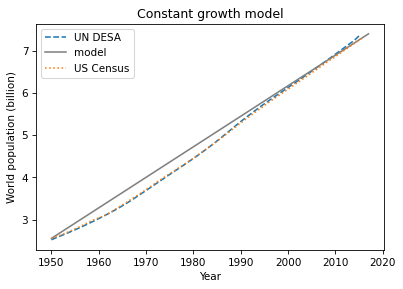

In [18]:
results = run_simulation1(system)
plot_results(census, un, results, 'Constant growth model')

## Proportional growth

Here's a more realistic model where the number of births and deaths is proportional to the current population.

In [19]:
def run_simulation2(system):
    """Run a model with proportional birth and death.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        births = system.birth_rate * results[t]
        deaths = system.death_rate * results[t]
        results[t+1] = results[t] + births - deaths
        
    return results

I picked a death rate that seemed reasonable and then adjusted the birth rate to fit the data.

In [20]:
system.death_rate = 0.01
system.birth_rate = 0.027

Here's what it looks like.

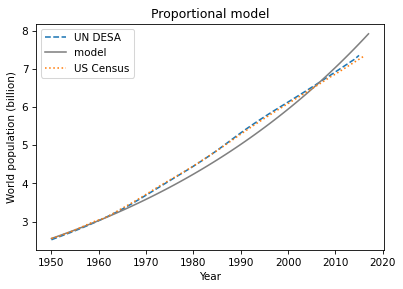

Saving figure to file figs/chap06-fig01.pdf


FileNotFoundError: [Errno 2] No such file or directory: 'figs/chap06-fig01.pdf'

<Figure size 450x300 with 0 Axes>

In [21]:
results = run_simulation2(system)
plot_results(census, un, results, 'Proportional model')
savefig('figs/chap06-fig01.pdf')

The model fits the data pretty well for the first 20 years, but not so well after that.

### Factoring out the update function

`run_simulation1` and `run_simulation2` are nearly identical except the body of the loop.  So we can factor that part out into a function.

In [22]:
def update_func1(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    return pop + births - deaths

The name `update_func` refers to a function object.

In [23]:
update_func1

<function __main__.update_func1(pop, t, system)>

Which we can confirm by checking its type.

In [24]:
type(update_func1)

function

`run_simulation` takes the update function as a parameter and calls it just like any other function.

In [25]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
        
    return results

Here's how we use it.

In [27]:

t_0 = census.index[0]
t_end = census.index[-1]
p_0 = census[t_0]

system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                birth_rate=0.027,
                death_rate=0.01)

namespace(t_0=1950,
          t_end=2016,
          p_0=2.557628654,
          birth_rate=0.027,
          death_rate=0.01)

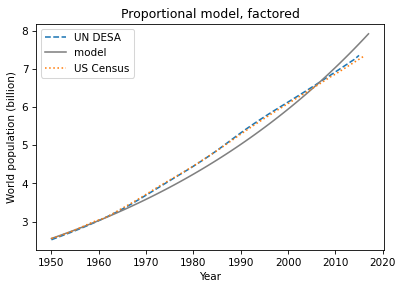

In [30]:
results = run_simulation(system, update_func1)
plot_results(census, un, results, 'Proportional model, factored')

Remember not to put parentheses after `update_func1`.  What happens if you try?

**Exercise:** When you run `run_simulation`, it runs `update_func1` once for each year between `t_0` and `t_end`.  To see that for yourself, add a print statement at the beginning of `update_func1` that prints the values of `t` and `pop`, then run `run_simulation` again.

t: 1950.0 pop: 2.557628654
t: 1951.0 pop: 0.1847835571255492
t: 1952.0 pop: 0.013350242589192974
t: 1953.0 pop: 0.000964528337709216
t: 1954.0 pop: 6.968524414658905e-05
t: 1955.0 pop: 5.034619577173802e-06
t: 1956.0 pop: 3.637411994071691e-07
t: 1957.0 pop: 2.6279574477886818e-08
t: 1958.0 pop: 1.898646718778012e-09
t: 1959.0 pop: 1.371734297204794e-10
t: 1960.0 pop: 9.910506064756386e-12
t: 1961.0 pop: 7.160142504252744e-13
t: 1962.0 pop: 5.173059816140376e-14
t: 1963.0 pop: 3.73743229907393e-15
t: 1964.0 pop: 2.700220118580202e-16
t: 1965.0 pop: 1.9508550537736583e-17
t: 1966.0 pop: 1.409453775507518e-18
t: 1967.0 pop: 1.0183021754741197e-19
t: 1968.0 pop: 7.357029642223934e-21
t: 1969.0 pop: 5.315306837222527e-22
t: 1970.0 pop: 3.840202928050755e-23
t: 1971.0 pop: 2.7744698434598e-24
t: 1972.0 pop: 2.0044989956234182e-25
t: 1973.0 pop: 1.4482104510621653e-26
t: 1974.0 pop: 1.0463030987518134e-27
t: 1975.0 pop: 7.559330715054026e-29
t: 1976.0 pop: 5.4614653180066544e-30
t: 1977.0 po

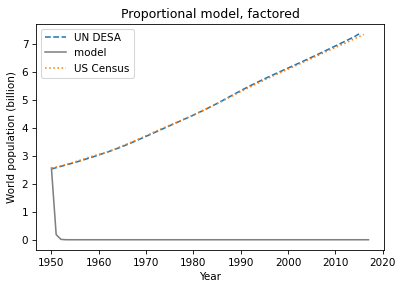

In [31]:
def update_func1(pop, t, system):
    print("t:", t, "pop:", pop)
    return pop * annual_growth

results = run_simulation(system, update_func1)
plot_results(census, un, results, 'Proportional model, factored')


### Combining birth and death

Since births and deaths get added up, we don't have to compute them separately.  We can combine the birth and death rates into a single net growth rate.

In [32]:
def update_func2(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    net_growth = system.alpha  * pop
    return pop + net_growth

Here's how it works:

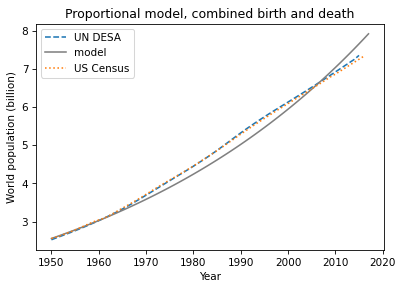

In [33]:
system.alpha = system.birth_rate - system.death_rate

results = run_simulation(system, update_func2)
plot_results(census, un, results, 'Proportional model, combined birth and death')

### Exercises

**Exercise:** Maybe the reason the proportional model doesn't work very well is that the growth rate, `alpha`, is changing over time.  So let's try a model with different growth rates before and after 1980 (as an arbitrary choice).

Write an update function that takes `pop`, `t`, and `system` as parameters.  The system object, `system`, should contain two parameters: the growth rate before 1980, `alpha1`, and the growth rate after 1980, `alpha2`.  It should use `t` to determine which growth rate to use.  Note: Don't forget the `return` statement.

Test your function by calling it directly, then pass it to `run_simulation`.  Plot the results.  Adjust the parameters `alpha1` and `alpha2` to fit the data as well as you can.



In [73]:
def growth_func3(t, pop, system):
    """Compute the population next year.
    
    t: current year
    pop: current population
    system: system object containing parameters of the model
    
    returns: population next year
    """
    if t < 1980:
        return system.alpha1 * pop
    else:
        return system.alpha2 * pop

In [75]:
p_0 = 2.557629

2.557629

In [77]:
system.alpha1 = 22 / 1000
system.alpha2 = 17 / 1000

def run_simulation1(system):
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in range(system.t_0, system.t_end):
        results[t+1] = results[t] + system.annual_growth
    
    return results


In [80]:
system.alpha1 = 19 / 1000
system.alpha2 = 15 / 1000

results3 = run_simulation(system, growth_func3)
results3.plot(label='model', color='gray')
plot_estimates()
decorate(title='Proportional growth, parameter changes over time')


TypeError: run_simulation() missing 1 required positional argument: 'p_0'